# Time Series Sales Forecasting with ARIMA

In [2]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import plotly.express as px

import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Wrangling

In [3]:
train=pd.read_csv("Dataset/train.csv", parse_dates =['date'])
train.shape

(3000888, 6)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [5]:
# check for duplicates

train.duplicated().any()

False

In [6]:
# check for missing values

train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
# drop columns

train.drop(columns=['id','store_nbr', 'family', 'onpromotion'], inplace=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   sales   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.8 MB


### Missing Dates

In [9]:
# Min and max dates (range of dates)
data_train_start = train.date.min()
data_train_end = train.date.max()

# Generate a date range from start_date to end_date
date_range = pd.date_range(start=data_train_start,end=data_train_end)

# Use the difference between the date_range and the unique dates in the sales data to find missing dates
missing_dates = date_range.difference(train['date'])

print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [10]:
# Create a DataFrame with missing dates
missing_dates_df = pd.DataFrame(missing_dates, columns=['date'])

# Concatenate the original DataFrame with the missing dates DataFrame
train_clean = pd.concat([train, missing_dates_df])

In [11]:
train_clean.isna().sum()

date     0
sales    4
dtype: int64

In [12]:
train_clean['sales'].fillna(0, inplace=True)
train_clean = train_clean.set_index('date')
train_clean.sort_index(inplace=True)

C:\Users\jmutonyi\AppData\Local\Temp\ipykernel_6560\3065107492.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean['sales'].fillna(0, inplace=True)


In [13]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000892 entries, 2013-01-01 to 2017-08-15
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   sales   float64
dtypes: float64(1)
memory usage: 45.8 MB


In [14]:
train_clean.isna().sum()

sales    0
dtype: int64

In [15]:
data_train_start = train_clean.index.min()
data_train_end = train_clean.index.max()

date_range = pd.date_range(start=data_train_start,end=data_train_end)
missing_dates_2 = date_range.difference(train_clean.index)
print("Missing dates:", missing_dates_2)

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Downsampling

Resampling to a lower frequency (downsampling) usually involves an aggregation operation — for example, computing monthly sales totals from daily data. It is also known as "aggregation" or "reduction," and is a data transformation technique used to reduce the granularity of data by reducing the number of data points in a dataset. 

It involves converting high-frequency or fine-grained data into lower-frequency or coarser-grained data. The main purpose of downsampling is to make data more manageable, reduce computational and storage requirements, and make it easier to visualize and analyze data over longer time periods. It can also help in cases where the fine-grained data contains a lot of noise, and reducing the data points can reveal underlying trends and patterns.

In [16]:
# Resample first into sum of daily sales

train_clean = train_clean.resample('D').sum()
print(train_clean.shape)

(1688, 1)


In [17]:
fig = px.line(train_clean, x=train_clean.index, y='sales', title='Sum of Daily Sales')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [18]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1688 entries, 2013-01-01 to 2017-08-15
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   1688 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB


In [19]:
# Save Daily Sales
import os

output_dir = 'Dataset'
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, 'Daily_Sales.csv')
train_clean.to_csv(output_file, index=True, header=True)

In [20]:
# resample data to weekly frequency and compute the sum of sales for each week

weekly_sales = train_clean.resample('W').sum()
print(weekly_sales.shape)

(242, 1)


In [21]:
fig = px.line(weekly_sales, x=weekly_sales.index, y='sales', title='Sum of Weekly Sales')
fig.update_xaxes(rangeslider_visible=True)

fig.show()

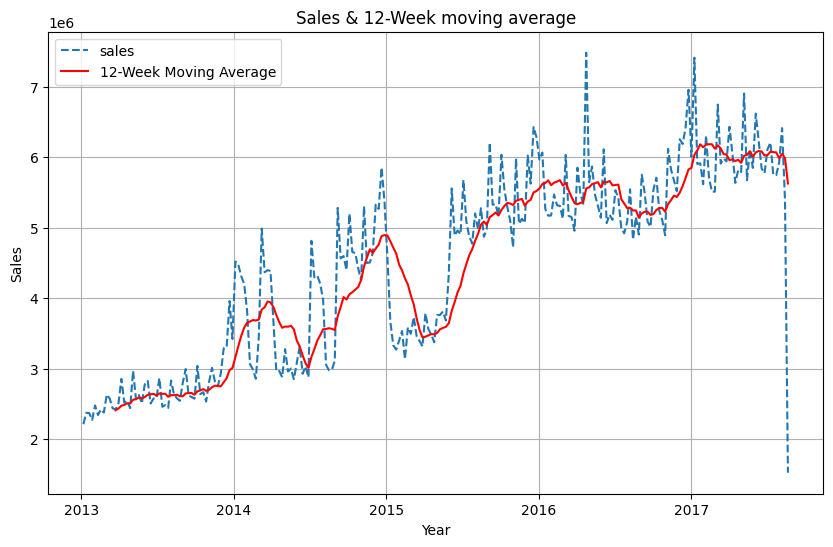

In [22]:
df_MA = weekly_sales.copy()
MA = df_MA['sales'].rolling(12).mean()

plt.figure(figsize=(10,6))
plt.plot(df_MA.index, df_MA.sales, '--', label='sales')
plt.plot(df_MA.index, MA, label='12-Week Moving Average', color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()
plt.title('Sales & 12-Week moving average')
plt.show()

## Stationarity Test

A time series has to have some statistical properties [to be able to stationary](https://python.plainenglish.io/time-series-analysis-mastering-the-concepts-of-stationarity-c9fc489893cf):

- **Constant mean**: There is no trend over time.
- **Constant variance, covariance**: The scale of the data doesn’t change and the relationship between observations is consistent.
- **No seasonality**: Statistical properties of seasonal data changes regularly. Therefore, there is a pattern of change in the mean.

- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary

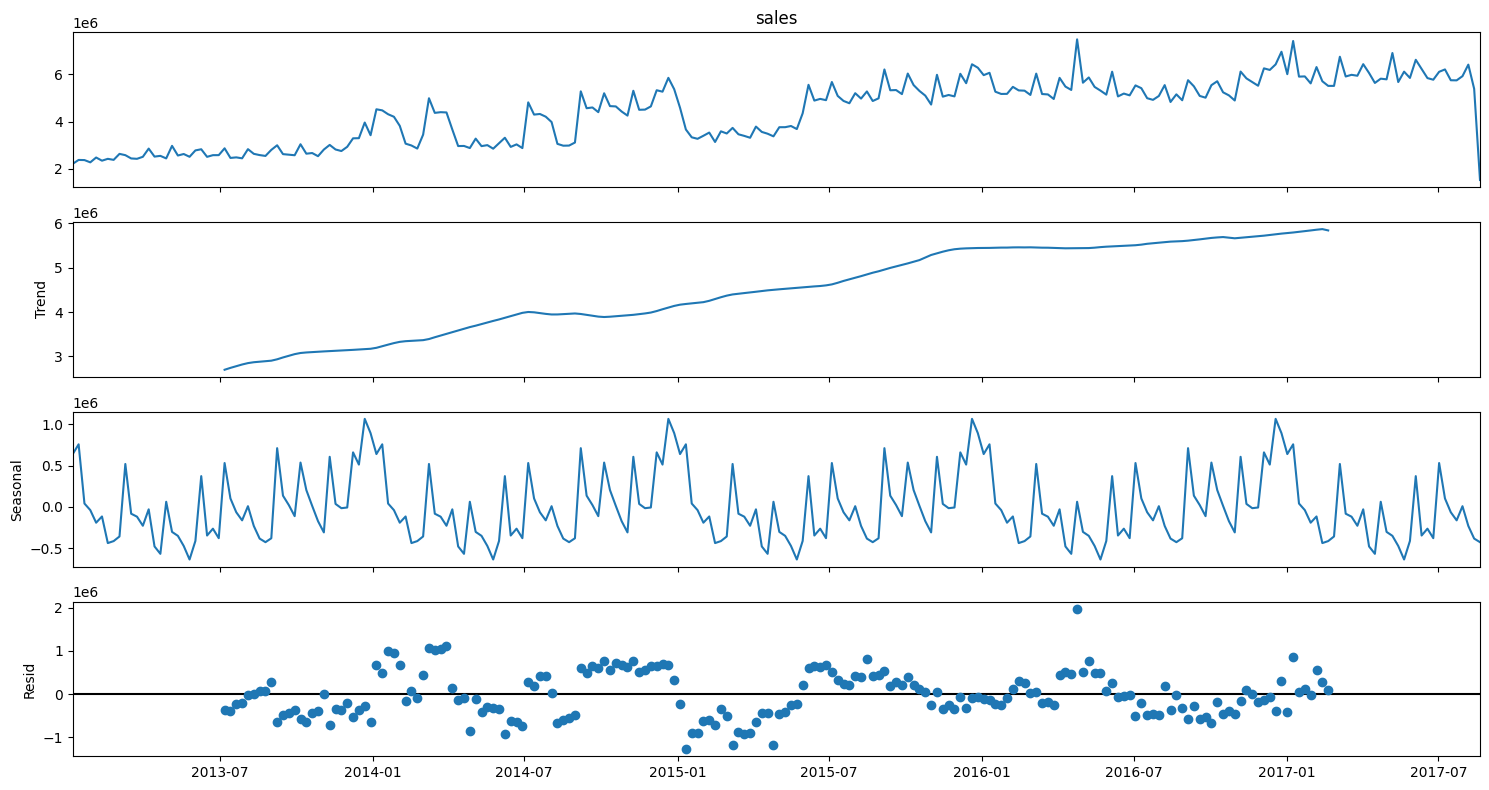

In [23]:
rcParams['figure.figsize'] = 15,8
decompose_series = sm.tsa.seasonal_decompose(weekly_sales['sales'], model='additive')
decompose_series.plot()
plt.show()

- Increasing trend and seasonality variations

In [24]:
adf_result = adfuller(weekly_sales['sales'])
print( f'ADF Statistic: {adf_result[ 0 ]}' )
print( f'p-value: {adf_result[ 1 ]}' )
print( f'No. of lags used: {adf_result[ 2 ]}' )
print( f'No. of observations used : {adf_result[ 3 ]}' )
print( 'Critical Values:' )
for k, v in adf_result[ 4 ].items():
 print( f'{k} : {v}' )
 if adf_result[1] < 0.05:
    print('Series is stationary')
else:
    print('Series is not stationary')

ADF Statistic: -1.9137834914190974
p-value: 0.32560496181472726
No. of lags used: 9
No. of observations used : 232
Critical Values:
1% : -3.458854867412691
5% : -2.8740800599399323
10% : -2.573453223097503
Series is not stationary


- We fail to reject the null hypothesis that the series has a unit root (is non-stationary)

### Differencing

- Differencing is a technique used to remove trends or seasonality from a time series data. It involves subtracting the previous value from the current value to detect and remove patterns that vary over time.

In [25]:
#Convert time series to stationary by removing trend and seasonality

df_log = np.log(weekly_sales)
weekly_sales_diff = df_log.diff(periods= 1 )

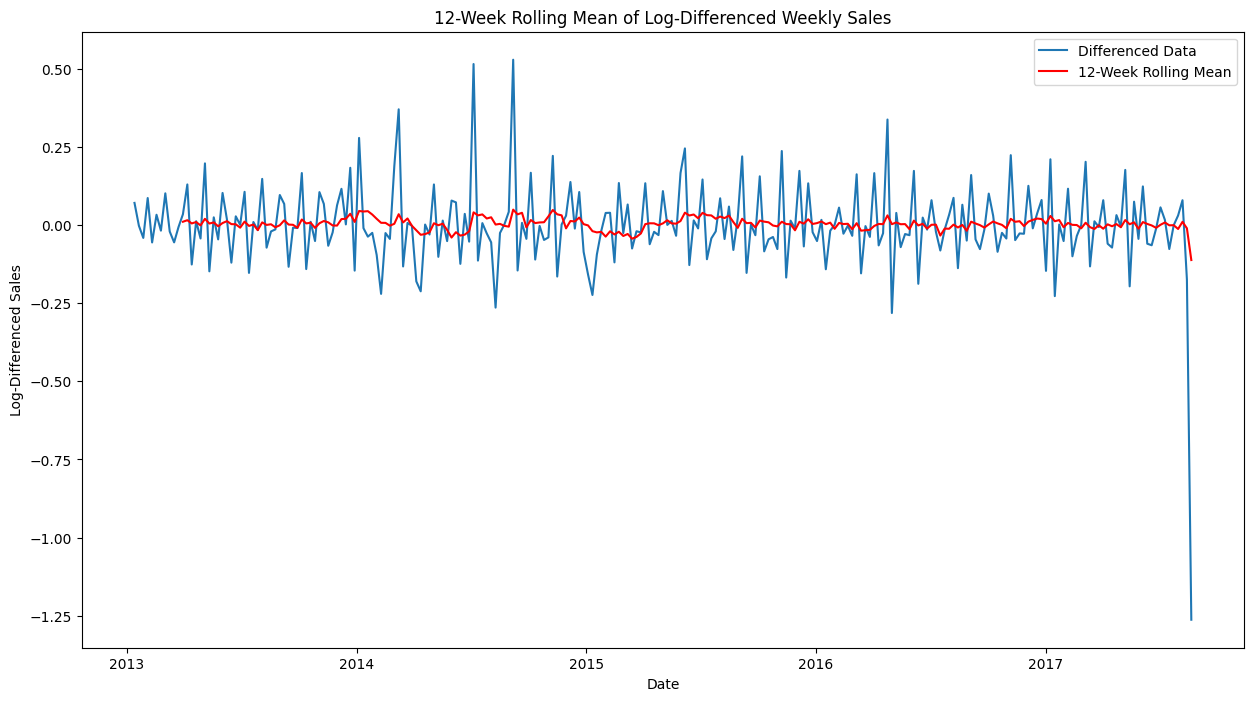

In [26]:
plt.plot(weekly_sales_diff.index, weekly_sales_diff['sales'], '-')
plt.plot(weekly_sales_diff.rolling(12).mean(), color='red')
plt.xlabel('Date')
plt.ylabel('Log-Differenced Sales')
plt.title('12-Week Rolling Mean of Log-Differenced Weekly Sales')
plt.legend(['Differenced Data', '12-Week Rolling Mean'])
plt.show()

In [27]:
weekly_sales_diff = weekly_sales_diff.dropna()

In [28]:
adf_result = adfuller(weekly_sales_diff['sales'])

# Print ADF test results
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used: {adf_result[3]}')
print('Critical Values:')
for k, v in adf_result[4].items():
    print(f'{k}: {v}')

# Print stationarity status
if adf_result[1] < 0.05:
    print('Series is stationary')
else:
    print('Series is not stationary')

ADF Statistic: -3.5690917186209674
p-value: 0.006380175375407389
No. of lags used: 8
No. of observations used: 232
Critical Values:
1%: -3.458854867412691
5%: -2.8740800599399323
10%: -2.573453223097503
Series is stationary


### Autocorrelation Function (ACF):

Autocorrelation refers to the correlation between the past values in a time series. It measures the linear relationship between lagged values in the series. The ACF plot or correlogram is used to display the autocorrelation in a time series by lag. The correlation coefficient between -1 and 1 is displayed on the y-axis and the lags displayed on the x-axis. 

### Partial Autocorrelation Function (PACF):

PACF gives the partial correlation of a stationary series with its lagged values not accounted for by prior lagged observations. This gives an overview of the relationship between an observation in a series and observations in previous time steps while removing interfering observations. The PACF at a specific lag is the correlation that occurs after removing the effect of any correlations as a result of shorter lags. In contrast to ACF, it controls for other lags. 

The ACF and PACF plots are displayed as bar charts showing confidence intervals at 95% and 99% as horizontal lines across the bars. Any bar that crosses these intervals are deemed to be more significant and worth noting.

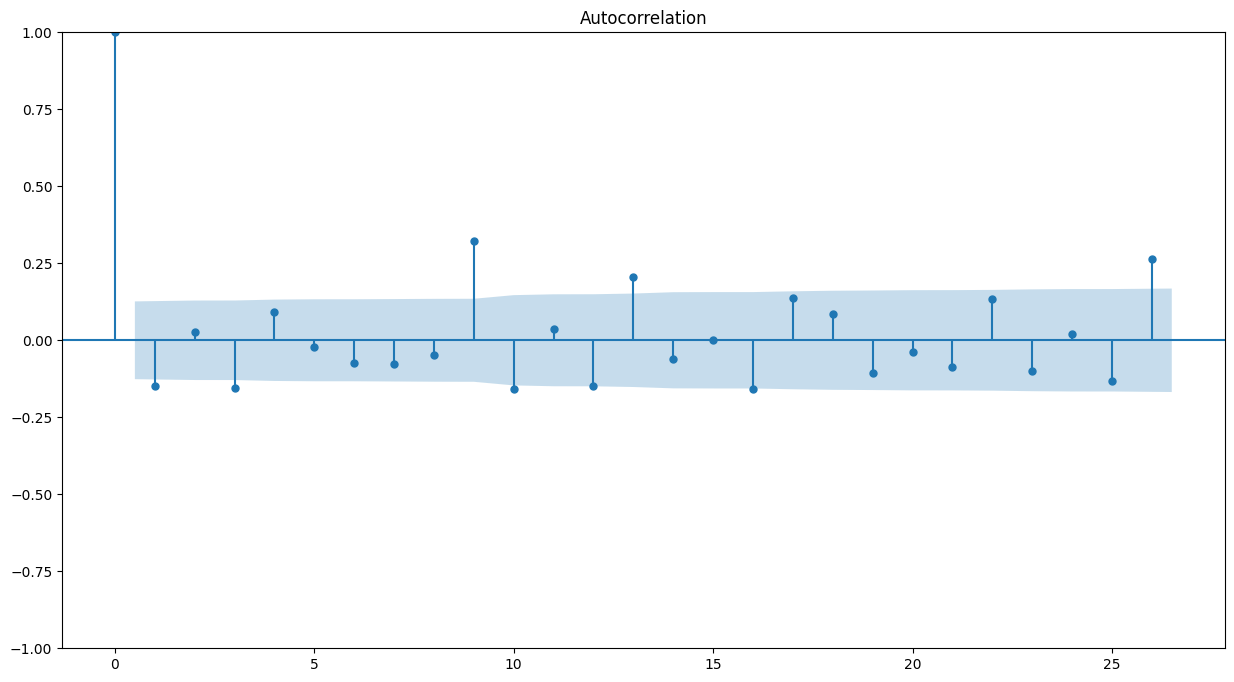

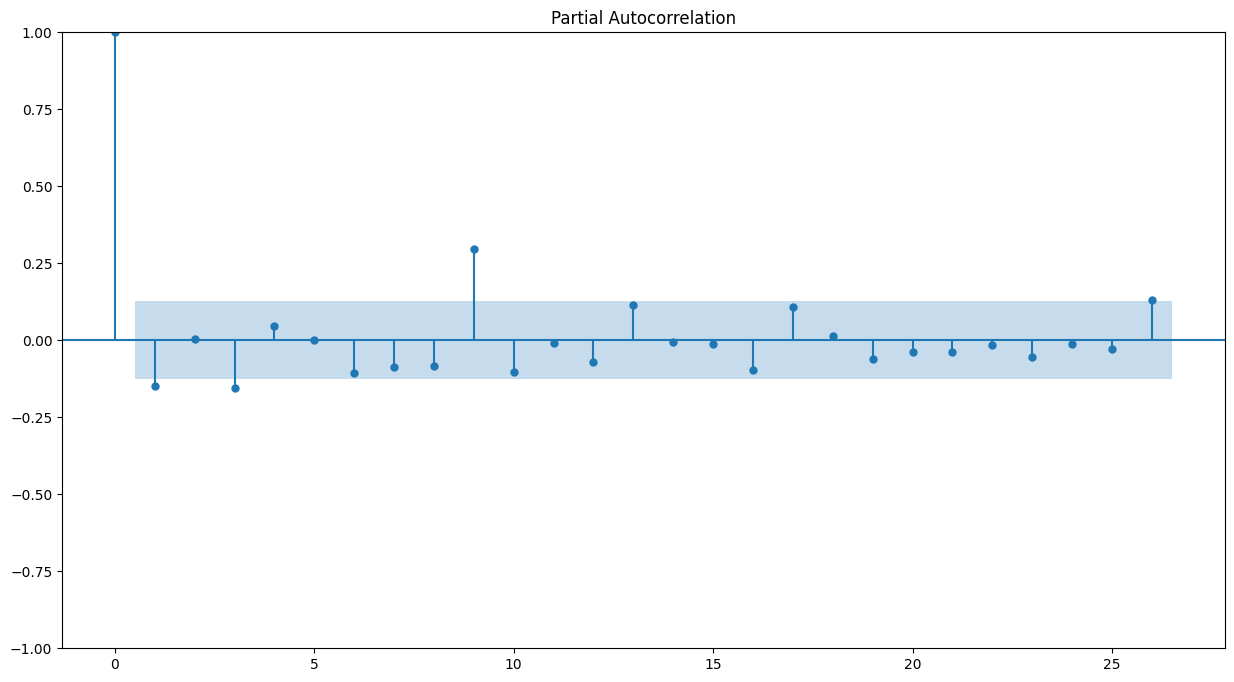

In [29]:
acf = plot_acf(weekly_sales_diff['sales'].dropna(), lags = 26)
pacf = plot_pacf(weekly_sales_diff['sales'].dropna(), lags = 26)

In [30]:
# Specify the date to split the data
split_date = '2017-01-01'

# Create train and test splits based on the index order
training_set = weekly_sales_diff.loc[weekly_sales_diff.index < split_date]
eval_set = weekly_sales_diff.loc[weekly_sales_diff.index >= split_date]

training_set.shape, eval_set.shape

((207, 1), (34, 1))

## Modeling

### AR

In [31]:
#AR
AR_model = ARIMA(training_set['sales'], order=( 9 , 0 , 0 ))
AR_model_results = AR_model.fit()
AR_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  207
Model:                 ARIMA(9, 0, 0)   Log Likelihood                 192.871
Date:                Mon, 17 Jun 2024   AIC                           -363.742
Time:                        19:46:51   BIC                           -327.082
Sample:                    01-13-2013   HQIC                          -348.917
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.005      1.143      0.253      -0.004       0.015
ar.L1         -0.2595      0.066     -3.911      0.000      -0.390      -0.129
ar.L2         -0.0591      0.093     -0.637      0.524      -0.241       0.123
ar.L3         -0.1872      0.076     -2.463      0.014      -0.336      -0.038
ar.L4         -0.0336      0.059     -0.566      0.572      -0.150       0.083
ar.L5         -0.1379      0.054     -2.549      0.011      -0.244      -0.032
ar.L6         -0.1413      0.088     -1.602      0.109      -0.314       0.032
ar.L7         -0.1826      0.088     -2.069      0.039      -0.356      -0.010
ar.L8         -0.1017      0.074     -1.380      0.168      -0.246       0.043
ar.L9          0.3846      0.055      6.972      0.000       0.277       0.493
sigma2         0.0090      0.001     14.661      0.000       0.008       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               109.59
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.49
Prob(H) (two-sided):                  0.81   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Make predictions using the AR model on train and evaluation data

AR_pred = AR_model_results.predict (start = len(training_set['sales']),
                           end = len(training_set['sales']) + len(eval_set['sales']) - 1,
                           dynamic = False
                           )

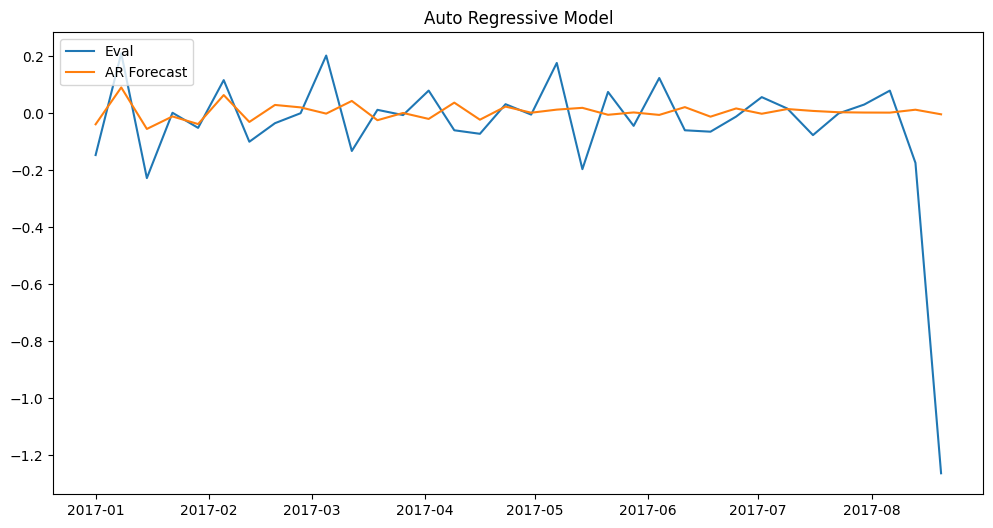

In [33]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (AR_pred, label = 'AR Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Model')
plt.show()

In [34]:
mse = mean_squared_error(eval_set['sales'], AR_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], AR_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], AR_pred).round(2)

# Create results DataFrame
results_1 = pd.DataFrame([['AR', mse, rmse, mae]], columns=['Model', 'MSE', 'RMSE', 'MAE'])

results_1

,Model,MSE,RMSE,MAE
0,AR,0.056141,0.24,0.11


### ARIMA

In [35]:
# We use pmdarima to determine the best parameter for our ARIMA model.

from pmdarima import auto_arima

stepwise_fit = auto_arima(training_set['sales'], trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-298.382, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-310.825, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-311.967, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-299.915, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-310.844, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-308.967, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-313.037, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-317.020, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-312.074, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-317.298, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-310.097, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-315.008, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(2, 0, 4)   Log Likelihood                 172.333
Date:                Mon, 17 Jun 2024   AIC                           -330.667
Time:                        19:47:00   BIC                           -307.338
Sample:                    01-13-2013   HQIC                          -321.233
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6677      0.130    -12.795      0.000      -1.923      -1.412
ar.L2         -0.7371      0.123     -6.000      0.000      -0.978      -0.496
ma.L1          1.5652      0.123     12.766      0.000       1.325       1.805
ma.L2          0.2524      0.149      1.696      0.090      -0.039       0.544
ma.L3         -0.7321      0.122     -6.002      0.000      -0.971      -0.493
ma.L4         -0.4026      0.063     -6.379      0.000      -0.526      -0.279
sigma2         0.0112      0.001     12.750      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   2.12   Jarque-Bera (JB):                87.75
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.78
Prob(H) (two-sided):                  0.93   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_2 = ARIMA(training_set['sales'], order=(2,0,4))
model_2_fit = model_2.fit()
model_2_fit.summary()

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  207
Model:                 ARIMA(2, 0, 4)   Log Likelihood                 168.672
Date:                Mon, 17 Jun 2024   AIC                           -321.343
Time:                        19:48:23   BIC                           -294.682
Sample:                    01-13-2013   HQIC                          -310.561
                         - 12-25-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.674      0.094      -0.001       0.010
ar.L1         -0.6924      0.247     -2.799      0.005      -1.177      -0.208
ar.L2          0.1548      0.235      0.660      0.509      -0.305       0.614
ma.L1          0.4238      0.237      1.786      0.074      -0.041       0.889
ma.L2         -0.4507      0.174     -2.591      0.010      -0.792      -0.110
ma.L3         -0.2225      0.158     -1.410      0.158      -0.532       0.087
ma.L4         -0.2809      0.101     -2.784      0.005      -0.479      -0.083
sigma2         0.0115      0.001     11.602      0.000       0.010       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                91.08
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.95
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
# Make predictions on the test data

ARIMA_pred = model_2_fit.predict(start=len(training_set['sales']),
                                 end=len(training_set['sales']) + len(eval_set['sales']) - 1,
                                 )

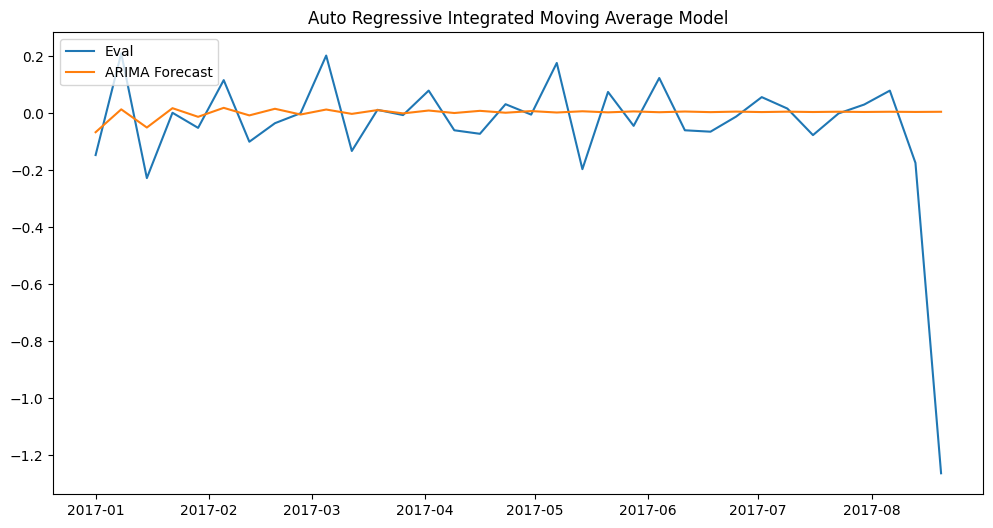

In [41]:
# plot the evaluation and model predictions

plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (ARIMA_pred, label = 'ARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Auto Regressive Integrated Moving Average Model')
plt.show()

In [43]:
mse = mean_squared_error(eval_set['sales'], ARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], ARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], ARIMA_pred).round(2)


model_results = pd.DataFrame([['ARIMA', mse, rmse, mae]], columns = ['Model', 'MSE', 'RMSE', 'MAE'])
results_2 = pd.concat([results_1, model_results], ignore_index=True)
results_2

,Model,MSE,RMSE,MAE
0,AR,0.056141,0.24,0.11
1,ARIMA,0.056622,0.24,0.11


In [44]:
model_3 = SARIMAX(training_set['sales'], order=(2,0,4), seasonal_order=(2,0,4,12)) 
model_3_fit = model_3.fit()
model_3_fit.summary()

c:\Users\jmutonyi\Desktop\Data Science\Azubi Data Analytics\P3\Time-Series-Sales-Prediction-ARIMA\.env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              sales   No. Observations:                  207
Model:             SARIMAX(2, 0, 4)x(2, 0, 4, 12)   Log Likelihood                 179.164
Date:                            Mon, 17 Jun 2024   AIC                           -332.329
Time:                                    19:51:56   BIC                           -289.003
Sample:                                01-13-2013   HQIC                          -314.808
                                     - 12-25-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4487      0.271     -1.658      0.097      -0.979       0.082
ar.L2          0.4063      0.240      1.693      0.090      -0.064       0.877
ma.L1          0.2724      0.274      0.993      0.321      -0.266       0.810
ma.L2         -0.6338      0.216     -2.932      0.003      -1.058      -0.210
ma.L3         -0.1096      0.176     -0.624      0.532      -0.454       0.234
ma.L4         -0.1695      0.140     -1.210      0.226      -0.444       0.105
ar.S.L12      -0.3340      0.388     -0.861      0.389      -1.095       0.427
ar.S.L24       0.0862      0.430      0.200      0.841      -0.757       0.929
ma.S.L12       0.3204      0.390      0.822      0.411      -0.444       1.084
ma.S.L24      -0.0697      0.433     -0.161      0.872      -0.919       0.779
ma.S.L36      -0.1123      0.105     -1.072      0.284      -0.317       0.093
ma.S.L48       0.2802      0.107      2.621      0.009       0.071       0.490
sigma2         0.0099      0.001     11.366      0.000       0.008       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                69.87
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.74
Prob(H) (two-sided):                  0.94   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
SARIMA_pred = model_3_fit.predict(start=len(training_set['sales']),
                                 end=len(training_set['sales']) + len(eval_set['sales']) - 1)

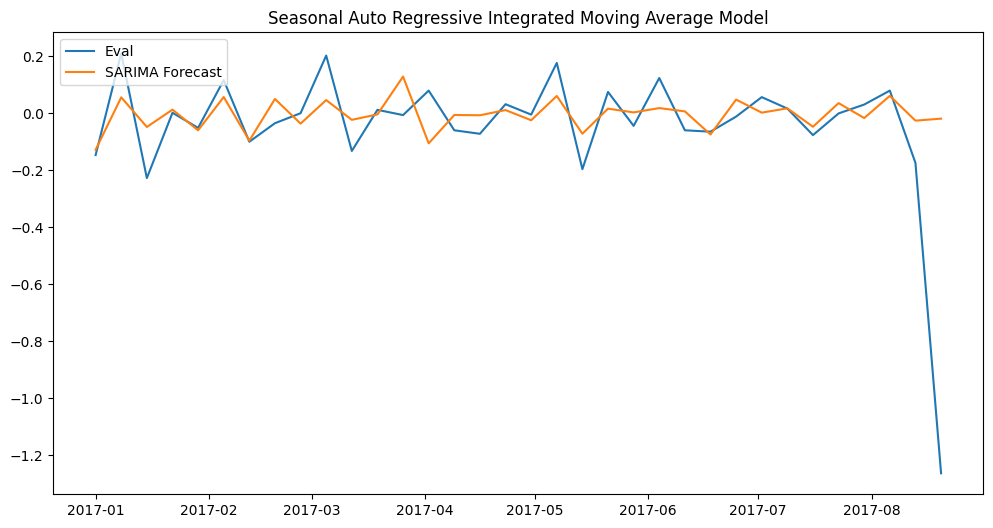

In [46]:
plt.figure(figsize = (12,6))
plt.plot(eval_set['sales'], label = 'Eval')
plt.plot (SARIMA_pred, label = 'SARIMA Forecast')
plt.legend(loc='upper left')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

In [47]:
mse = mean_squared_error(eval_set['sales'], SARIMA_pred)
rmse = np.sqrt(mean_squared_error(eval_set['sales'], SARIMA_pred)).round(2)
mae = mean_absolute_error(eval_set['sales'], SARIMA_pred).round(2)


model_results = pd.DataFrame([['SARIMA', mse, rmse, mae]], columns = ['Model', 'MSE', 'RMSE', 'MAE'])
results_3 = pd.concat([results_2, model_results], ignore_index=True)
results_3

,Model,MSE,RMSE,MAE
0,AR,0.056141,0.24,0.11
1,ARIMA,0.056622,0.24,0.11
2,SARIMA,0.052806,0.23,0.10


In [ ]:
# Predictions

# future_dates = pd.DataFrame(pd.date_range(start='2017-08-16', end='2017-08-31', freq='D'), columns=['dates'])
# future_dates.set_index('dates', inplace=True)
# future_dates.head()

##model_2_fit.predict(start=future_dates.index[0], end=future_dates.index[-1])